### Assignment 2: State prediction

In this assignment you are learning to estimate state from the acquired range-rate data.
You will capture the data and look at differnt arc settings.

In this estimation you are using a full SH model of the gravity field of Earth

In [1]:
# Load standard modules
import statistics
# Uncomment the following to make plots interactive
# %matplotlib widget
from matplotlib import pyplot as plt

from propagation_functions.environment import *
from propagation_functions.propagation import *
from estimation_functions.estimation import *
from estimation_functions.observations_data import *

from utility_functions.time import *
from utility_functions.tle import *

# Load tudatpy modules
from tudatpy.kernel import constants
from tudatpy.kernel.interface import spice
from tudatpy.kernel import numerical_simulation
from tudatpy.kernel.numerical_simulation import propagation_setup
from tudatpy.kernel.numerical_simulation import estimation_setup
from tudatpy.kernel.astro import element_conversion

In [2]:
# Start of time
j2000_days = 2451545.0

# Define import folder
metadata_folder = 'metadata/'
data_folder = 'data/'

# Files to be uploaded
metadata = ['Delfi-C3_32789_202004011044.yml', 'Delfi-C3_32789_202004011219.yml', 'Delfi-C3_32789_202004020904.yml', 'Delfi-C3_32789_202004021953.yml',
            'Delfi-C3_32789_202004031031.yml', 'Delfi-C3_32789_202004031947.yml', 'Delfi-C3_32789_202004041200.yml', 'Delfi-C3_32789_202004061012.yml',
            'Delfi-C3_32789_202004062101.yml', 'Delfi-C3_32789_202004062236.yml', 'Delfi-C3_32789_202004072055.yml', 'Delfi-C3_32789_202004072230.yml',
            'Delfi-C3_32789_202004081135.yml']

data = ['Delfi-C3_32789_202004011044.DOP1C', 'Delfi-C3_32789_202004011219.DOP1C', 'Delfi-C3_32789_202004020904.DOP1C', 'Delfi-C3_32789_202004021953.DOP1C',
        'Delfi-C3_32789_202004031031.DOP1C', 'Delfi-C3_32789_202004031947.DOP1C', 'Delfi-C3_32789_202004041200.DOP1C', 'Delfi-C3_32789_202004061012.DOP1C',
        'Delfi-C3_32789_202004062101.DOP1C', 'Delfi-C3_32789_202004062236.DOP1C', 'Delfi-C3_32789_202004072055.DOP1C', 'Delfi-C3_32789_202004072230.DOP1C',
        'Delfi-C3_32789_202004081135.DOP1C']

# Specify which metadata and data files should be loaded (this will change throughout the assignment)
# 1. & 2. only one pass
# 3. & 4. all passes
indices_files_to_load = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
# indices_files_to_load = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [3]:
# Retrieve initial epoch and state of the first pass
initial_epoch, initial_state_teme = get_tle_initial_conditions(metadata_folder + metadata[0])
start_recording_day = get_start_next_day(initial_epoch)

# Calculate final propagation_functions epoch
nb_days_to_propagate = 9
final_epoch = start_recording_day + nb_days_to_propagate * 86400.0

print('initial_epoch', initial_epoch)
print('final_epoch', final_epoch)

# Load and process observations
passes_start_times, passes_end_times, observation_times, observations_set = load_and_format_observations(data_folder, data, indices_files_to_load)


initial_epoch 638874855.9999838
final_epoch 639662400.0


In [4]:
# Define tracking arcs and retrieve the corresponding arc starting times (this will change throughout the assignment)
# Three options: one arc per pass ('per_pass'), one arc per day ('per_day') and one arc per week ('per_week')
arc_start_times, arc_end_times = define_arcs('per_pass', passes_start_times, passes_end_times)

print('arc_start_times', arc_start_times)
print('arc_end_times', arc_end_times)


arc_start_times [638999112.2902441, 639004792.9395922, 639079478.5132854, 639118637.3597755, 639171156.9996446, 639204584.0595292, 639262872.5293524, 639429218.2454671, 639468253.5355089, 639473938.0450155, 639554392.7653619, 639559986.4245406, 639606950.3670406]
arc_end_times [639006990.6902441, 639012597.3395922, 639087228.7132853, 639126295.7597755, 639179023.1996447, 639212299.4595293, 639270686.9293524, 639437110.645467, 639476058.7355088, 639481473.8450155, 639562030.5653619, 639567768.4245406, 639614606.5670407]


In [5]:
# Define propagation_functions environment
mass_delfi = 2.2
reference_area_delfi = 0.035
drag_coefficient_delfi = 1.4
srp_coefficient_delfi = 2.4
bodies = define_environment(mass_delfi, reference_area_delfi, drag_coefficient_delfi, srp_coefficient_delfi, multi_arc_ephemeris=False)

# Set Delfi's initial state of Delfi
initial_state = element_conversion.teme_state_to_j2000(initial_epoch, initial_state_teme)


# Define accelerations exerted on Delfi
# Warning: point_mass_gravity and spherical_harmonic_gravity accelerations should not be defined simultaneously for a single body
acceleration_models = dict(
    Sun={
        'point_mass_gravity': True,
        'solar_radiation_pressure': True
    },
    Moon={
        'point_mass_gravity': True
    },
    Earth={
        'point_mass_gravity': False,
        'spherical_harmonic_gravity': True,
        'drag': True
    },
    Venus={
        'point_mass_gravity': True
    },
    Mars={
        'point_mass_gravity': True
    },
    Jupiter={
        'point_mass_gravity': True
    }
)
accelerations = create_accelerations(acceleration_models, bodies)

# Propagate dynamics and retrieve Delfi's initial state at the start of each arc
orbit = propagate_initial_state(initial_state, initial_epoch, final_epoch, bodies, accelerations)
arc_wise_initial_states = get_initial_states(bodies, arc_start_times)


===============  STARTING SINGLE-ARC PROPAGATION  ===============

PROCESSED STATE VECTOR CONTENTS: 
[Vector entries], content description
[0:5], Translational state of body Delfi w.r.t. Earth

DEPENDENT VARIABLE VECTOR CONTENTS: 
[Vector entries], content description
[0:5], Kepler elements of Delfi w.r.t. Earth
[6], Spherical position angle latitude angle of Delfi w.r.t. Earth
[7], Spherical position angle longitude angle of Delfi w.r.t. Earth




Warning when processing deprecated propagator settitngs, integrator settings defined independently, and in propagator settings


In [6]:
# Redefine environment to allow for multi-arc dynamics propagation_functions
bodies = define_environment(mass_delfi, reference_area_delfi, drag_coefficient_delfi, srp_coefficient_delfi, multi_arc_ephemeris=True)
accelerations = create_accelerations(acceleration_models, bodies)

# Define multi-arc propagator settings
multi_arc_propagator_settings = define_multi_arc_propagation_settings(arc_wise_initial_states, arc_start_times, arc_end_times, bodies, accelerations)

# Create the DopTrack station
define_doptrack_station(bodies)


# Define default observation settings
# Specify on which time interval the observation bias(es) should be defined. This will change throughout the assignment (can be 'per_pass', 'per_arc', 'global')
# Noting that the arc duration can vary (see arc definition line 64)
bias_definition = 'per_pass'
Doppler_models = dict(
    absolute_bias={
        'activated': True,
        'time_interval': bias_definition
    },
    relative_bias={
        'activated': True,
        'time_interval': bias_definition
    },
    time_bias={
        'activated': True,
        'time_interval': bias_definition
    }
)
observation_settings = define_observation_settings(Doppler_models, passes_start_times, arc_start_times)

# Define parameters to estimate
parameters_list = dict(
    initial_state_delfi={
        'estimate': True,
        'type': 'per_arc' # Do not modify this entry. To modify the frequency at which Delfi's initial state is estimated,
                          # the tracking arc duration should be directly modified (go to line 64 and change the arc definition)
    },
    absolute_bias={
        'estimate': True,
        'type': bias_definition # Do not modify this entry, it should be consistent with the bias definition above
    },
    relative_bias={
        'estimate': True,
        'type': bias_definition # Idem
    },
    time_bias={
        'estimate': True,
        'type': bias_definition # Idem
    }
)
parameters_to_estimate = define_parameters(parameters_list, bodies, multi_arc_propagator_settings, initial_epoch,
                                           arc_start_times, passes_start_times, Doppler_models)
estimation_setup.print_parameter_names(parameters_to_estimate)

# Create the estimator object
estimator = numerical_simulation.Estimator(bodies, parameters_to_estimate, observation_settings, multi_arc_propagator_settings)

print('max observation_times', max(observation_times))
# Simulate (ideal) observations
ideal_observations = simulate_observations_from_estimator(observation_times, estimator, bodies)


Parameter start index, Parameter definition
0, arc-wise translational state of (Delfi).
78, absolute arc-wise observation bias for observable: (OneWayDoppler) and link ends: (transmitter: (Delfi); receiver: (Earth, DopTrackStation))
91, relative arc-wise observation bias for observable: (OneWayDoppler) and link ends: (transmitter: (Delfi); receiver: (Earth, DopTrackStation))
104, arc-wise time drift observation bias for observable: (OneWayDoppler) and link ends: (transmitter: (Delfi); receiver: (Earth, DopTrackStation))

max observation_times 639610996.5670407
---------------  STARTING PROPAGATION FOR ARC 12  ----------------

PROCESSED STATE VECTOR CONTENTS: 
[Vector entries], content description
[0:5], Translational state of body Delfi w.r.t. Earth

DEPENDENT VARIABLE VECTOR CONTENTS: 
No dependent variables have been selected.

-----------------------------------------------------------------

---------------  STARTING PROPAGATION FOR ARC 12  ----------------

PROCESSED STATE VECTOR

# Run the estimation

Now you are all setup to run the estimation. In the following block the dynamic equations are set and the estimator knows what kind of parameters need to be estimated.

Press run. This can take a while, depending on your amount of data and settings

In [7]:
# Save the true parameters to later analyse the error
truth_parameters = parameters_to_estimate.parameter_vector
nb_parameters = len(truth_parameters)

# Perform estimation_functions
nb_iterations = 10
nb_arcs = len(arc_start_times)
pod_output = run_estimation(estimator, parameters_to_estimate, observations_set, nb_arcs, nb_iterations)

print(pod_output.formal_errors)

residuals = pod_output.residual_history
mean_residuals = statistics.mean(residuals[:,nb_iterations-1])
std_residuals = statistics.stdev(residuals[:,nb_iterations-1])

print('mean', mean_residuals)
print('standard deviation', std_residuals)


[1.70947354e+03 1.73979170e+03 1.39567528e+03 1.63433604e+00
 1.73925369e+00 1.39101372e+00 1.76400473e+03 1.91751835e+03
 1.52535107e+03 1.79728823e+00 1.58684654e+00 1.64887587e+00
 1.97857841e+03 1.91006849e+03 1.50529567e+03 1.69883074e+00
 1.86866638e+00 1.77263437e+00 1.67349254e+03 1.75576648e+03
 1.84656931e+03 1.98519576e+00 1.73991221e+00 1.39580183e+00
 1.75206847e+03 1.72728267e+03 1.39978201e+03 1.50319659e+00
 1.82828237e+00 1.36112150e+00 1.68084865e+03 1.77565748e+03
 1.91436451e+03 1.99052634e+00 1.83310089e+00 1.41748515e+00
 1.63704858e+03 1.92103931e+03 1.49487307e+03 1.77479607e+00
 1.41489128e+00 1.59986606e+00 1.80012246e+03 1.72232435e+03
 1.42131061e+03 1.36500932e+00 1.90074053e+00 1.38036378e+00
 1.61933421e+03 1.75213968e+03 1.55521698e+03 1.86643529e+00
 1.54831235e+00 1.35272474e+00 1.65117314e+03 1.81359740e+03
 1.82954498e+03 1.70450846e+00 1.94593740e+00 1.48512702e+00
 1.61476370e+03 1.76651910e+03 1.59986558e+03 1.86308445e+00
 1.55592285e+00 1.364119

# Inspect the results

The first number that we look at is final residual. This shows the difference (RMS???) between the observed range-rate and the final orbit model estimated by your program.

ontent description
[0:5], Translational state of body Delfi w.r.t. Earth

DEPENDENT VARIABLE VECTOR CONTENTS: 
No dependent variables have been selected.

-----------------------------------------------------------------

---------------  STARTING PROPAGATION FOR ARC 12  ----------------

PROCESSED STATE VECTOR CONTENTS: 
[Vector entries], content description
[0:5], Translational state of body Delfi w.r.t. Earth

DEPENDENT VARIABLE VECTOR CONTENTS: 
No dependent variables have been selected.

-----------------------------------------------------------------

---------------  STARTING PROPAGATION FOR ARC 12  ----------------

PROCESSED STATE VECTOR CONTENTS: 
[Vector entries], content description
[0:5], Translational state of body Delfi w.r.t. Earth

DEPENDENT VARIABLE VECTOR CONTENTS: 
No dependent variables have been selected.

-----------------------------------------------------------------

---------------  STARTING PROPAGATION FOR ARC 12  ----------------

PROCESSED STATE VECTOR C

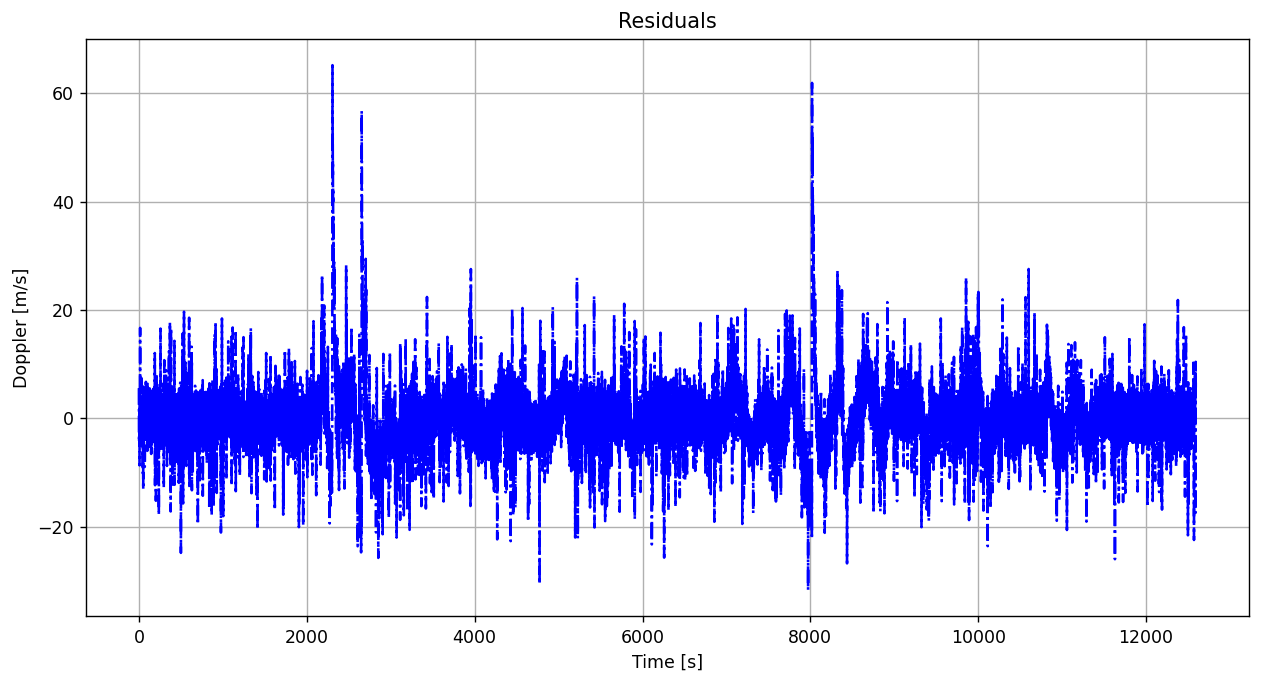

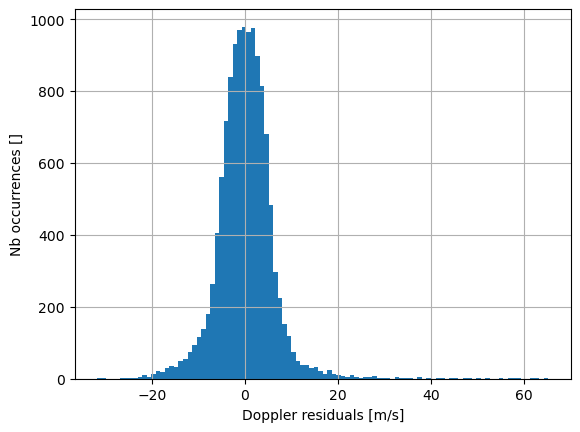

In [8]:
# Plot residuals
fig = plt.figure(figsize=(12,6), dpi=125)
ax = fig.add_subplot()
ax.set_title(f'Residuals')

# ax.plot(residuals[:,0], color='red', linestyle='-.')
# ax.plot(residuals[:,1], color='green', linestyle='-.')
# ax.plot(residuals[:,2], color='green', linestyle='-.')
ax.plot(residuals[:,nb_iterations-1],color='blue', linestyle='-.')

# ax.legend()
ax.set_xlabel('Time [s]')
ax.set_ylabel('Doppler [m/s]')
plt.grid()
plt.show()

# Plot residuals histogram
fig = plt.figure()
ax = fig.add_subplot()
# plt.hist(residuals[:,1],100)
plt.hist(residuals[:,nb_iterations-1],100)
ax.set_xlabel('Doppler residuals [m/s]')
ax.set_ylabel('Nb occurrences []')
plt.grid()
plt.show()

# Excercises

So, above you have a tool to estimate orbits from range-rate data. As, you have seen there are a lot of parameters to play with. Also, some of the observations are not of high quality. You will play around with the settings and deselecting observations to improve the orbit etsimation. For now, improving the orbit estimation is to reduce the final residual.

PLease document the Final Residual and inspect the residual plots

### Settings: deactivate parameters, arc length, dynamical model

We first going to play with the **estimated biases**. We assumed in assignment 1 that the linear frequency drift was due to an onboard clock or voltage drift. But, could it also be an orbit feature. We can test this by deactivating the bias estimation (set to False)

Please document the Final Residual and inspect the residual plots

A second parameter to play with is the **arc length**. This setting tells the estimator how much data is used per state estimation. So, `per_pass` means that every pass a state (an orbit solution) is estimated. Setting the arc length to `per_day` will generate orbits per day, using all data during the day. We have also included `per_week`, but for now this does not work properly yet, but that could change in assignment 3. Can you play with this setting and report on the results.

- Final residual when arc length is set to `per_pass`
- Final residual when arc length is set to `per_day`
- Final residual when arc length is set to `per_week`

You can also do this with the bias parameters, but because we strongly think that they are satellite related, we keep them on `per_pass`. However, in Assignment 3 your could play with those settings as well for certain dynamic model parameters.

In this assignment you are using the 'best' **dynamical model**. Try to find out what happens with the orbit estimation if you remove certain information from the dynamical model. Use per_pass arc length and estimate all biases. Then:

- Keep rest fixed, but turn off Earth drag
- Keep rest fixed, but now turn off solar radiation
- Keep rest fixed, but us a point mass model for Earth

Document in these scenarios what happens with the residual. Discuss why it is worse or better.

### Deselecting data 

Up until now we used 12??? passes of data. But we saw in the residuals filter that some passes show artifacts, glitches in the radio signal, start-up issues, or other measuring noise. We could deselect certain passes to improve our residuals? Would that also improve our orbit estimation?

- deselect certain passes by altering `indices_files_to_load`

Run the estimation again with perfect settings. Document your choices of deselecting certain passes and report on the resulting residuals and orbits. Are these better orbits? How do you know?

